In [1]:
import numpy as np
import py21cmfast as p21c

import matplotlib.pyplot as plt
%matplotlib inline

from py21cmfast import global_params
from py21cmfast import plotting

from vcb_gen import generate_vcb

/home/ram/anaconda3/envs/21cm/lib/python3.8/site-packages/py21cmfast/_cfg.py:57: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/ram/anaconda3/envs/21cm/lib/python3.8/site-packages/py21cmfast/_cfg.py:41: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [2]:
vcb, vcb_wr = generate_vcb(num_cubes=50)

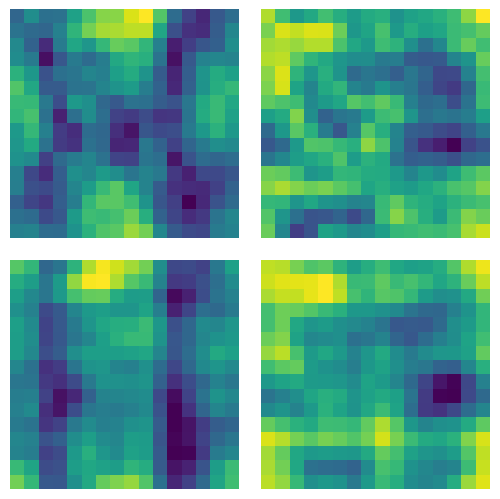

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))

for i in range(2):
    ax[0][i].imshow(vcb[i][0])
    ax[0][i].axis('off')

for i in range(2):
    ax[1][i].imshow(vcb_wr[i][0])
    ax[1][i].axis('off')

fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.1)

plt.show()

In [4]:
import torch
import torch.nn as nn

In [5]:
X=torch.tensor(np.reshape(vcb_wr[:45], (45, 1, 16, 16, 16)), dtype=torch.float32)
Y=torch.tensor(np.reshape(vcb[:45], (45, 1, 16, 16, 16)), dtype=torch.float32)

X_max=torch.max(X)
X_min=torch.min(X)

Y_max=torch.max(Y)
Y_min=torch.min(Y)

def normalize(T, T_max, T_min):
    a=2.0/(T_max - T_min)
    b=-(T_max + T_min)/(T_max - T_min)
    return a*T + b

def denormalize(T, T_max, T_min):
    a=2.0/(T_max - T_min)
    b=-(T_max + T_min)/(T_max - T_min)
    return (T-b)/a

In [78]:
channel_list=[1, 2, 2, 2, 4, 4, 2]

In [79]:
class BasicUNet(nn.Module):
    
    def __init__(self, channel_list):
        super().__init__()
        N=len(channel_list)
        self.down_layers = torch.nn.ModuleList([nn.Conv3d(channel_list[i], channel_list[i+1], kernel_size=3, padding=1) for i in range(0, N-1)])
        self.up_layers = torch.nn.ModuleList([nn.Conv3d(channel_list[N-1-i] + channel_list[N-1-i], channel_list[N-2-i], kernel_size=3, padding=1) for i in range(0, N-1)])
        self.act = nn.SiLU()

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) #store for skip-connection
            h.append(x) 
              
        for i, l in enumerate(self.up_layers):
            x = torch.cat((x, h.pop()), dim=1) #skip-connection from the down_layers.
            x = self.act(l(x))
            
        return x

In [80]:
Model=BasicUNet(channel_list=channel_list)
print('down_layers\n')
for _ in Model.down_layers:
    print(_)

print('up_layers\n')
for _ in Model.up_layers:
    print(_)

down_layers

Conv3d(1, 2, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
Conv3d(2, 2, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
Conv3d(2, 2, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
Conv3d(2, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
Conv3d(4, 2, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
up_layers

Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
Conv3d(8, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
Conv3d(8, 2, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
Conv3d(4, 2, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
Conv3d(4, 2, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
Conv3d(4, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))


In [95]:
N_epochs=2000
lr=1.0e-04
eps=0.0
loss=torch.nn.MSELoss()
loss_list=[]

In [96]:
optimizer = torch.optim.Adam(Model.parameters(), lr=lr, eps=eps)

for epoch in range(1, N_epochs + 1):
    optimizer.zero_grad()
    Y_pred = Model(X)
    loss_val = loss(Y, Y_pred)
    loss_val.backward()
    optimizer.step()
    loss_list.append(loss_val.detach().numpy())
    if epoch % 200 == 0:
        print("%d complete, loss_value = %f" % (epoch, loss_list[-1]), flush=True)

200 complete, loss_value = 3.719221
400 complete, loss_value = 3.673628


KeyboardInterrupt: 

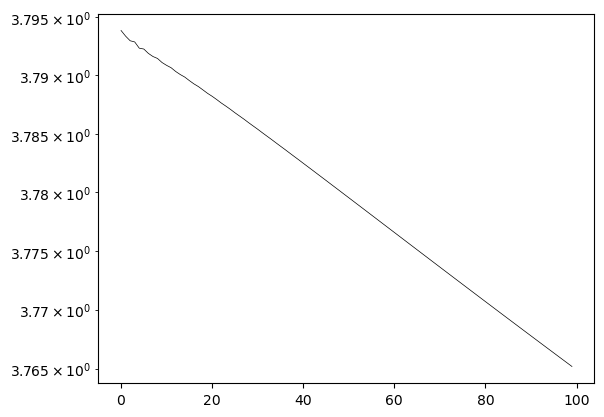

In [92]:
plt.semilogy(loss_list, ls='-', color='k', lw=0.5)
plt.show()

In [93]:
vcb_pred=np.reshape(Model(X).detach().numpy(), (45, 16, 16, 16))

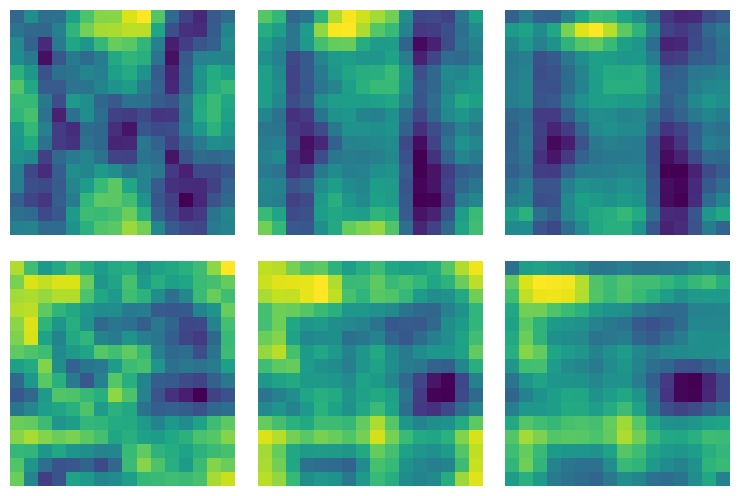

In [94]:
fig, ax = plt.subplots(2, 3, figsize=(9, 6))

vmax=np.max(vcb)
vmin=np.min(vcb)

for j in range(2):
    ax[j][0].imshow(vcb[j][0])
    ax[j][1].imshow(vcb_wr[j][0])
    ax[j][2].imshow(vcb_pred[j][0])

for j in range(2):
    for i in range(3):
        ax[j, i].axis('off')

fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.1)

In [77]:
from sklearn.metrics import mean_squared_error as mse

print(mse(vcb[:45].reshape(45, 16**3), vcb_wr[:45].reshape(45, 16**3))) #between original and wr images
print(mse(vcb[:45].reshape(45, 16**3), vcb_pred.reshape(45, 16**3))) #between original and reconstructed

3.5367449472011216
3.6873357
